#  Converting between global and local axis systems

IN: MDCM charges, atom positions (from cube file), reference frames   
OUT: MDCM charges shifted to reflect the new local axis system

## 1. Load initial variables
Note: in this code, atoms are 0 indexed
For the MDCM module in CHARMM the atoms are labelled from 1

In [1]:
import numpy as np
import os, sys
from scipy.spatial import distance
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import sqrt 
#%matplotlib ipympl

home_path = "/home/boittier/Documents/AdjustReference-System/"
#home_path = "/home/eric/Documents/PhD/AdjustReference-System/"
sys.path.insert(1, home_path)
from Cube import read_charges_refined, read_cube

BOHR_TO_ANGSTROM = 0.529177

#  Define Variables

# # F-butadiene example
# folder = "fbuta/pos1/"
# xyz_file_name = home_path + folder + "36_charges_refined.xyz"
# pcube = home_path + folder + "B.p.cube"
# frame_file = home_path + folder + "frames.txt"

# Water Example
#folder = "water_simple/"
folder = "water/"
xyz_file_name = home_path + folder + "8_charges_refined.xyz"
pcube = home_path + folder + "Water_5_5_4.pot.cube"
frame_file = home_path + folder + "frames.txt"

# Open XYZ file
xyz_file = open(xyz_file_name).readlines()
#  read number of charges from first line (xyz format)
n_charges = int(xyz_file[0])
charge_lines = xyz_file[2:n_charges+2]
# Read atoms and charges
c_positions = []
c_charges = []
for charge in charge_lines:
    on, x, y, z, c = charge.split()
    c_positions.append([float(x), float(y) , float(z)])
    c_charges.append(float(c))
    
# Open Cube file
pcube_data, pcube_meta = read_cube(pcube)
atom_positions = []
atom_names = []
for i in pcube_meta["atoms"]:
    atom = list(i[1])
    atom_positions.append([x *BOHR_TO_ANGSTROM for x in atom[1:]])

    atom_names.append(atom[1])
n_atoms = len(atom_names)

# Match each charge to a nucleus
charge_atom_associations = []
atom_charge_dict = {}
for i_charge in range(n_charges):
    min_distance = np.Inf #  initial distance, which can be compared to find smaller values
    for j_atom in range(n_atoms):       
        d = distance.euclidean(c_positions[i_charge], atom_positions[j_atom])
        if d < min_distance:
            atom_association = j_atom
            min_distance = d
    charge_atom_associations.append([i_charge, atom_association])
    
    if atom_association not in list(atom_charge_dict.keys()):
        atom_charge_dict[atom_association] = [i_charge]
    else:
        atom_charge_dict[atom_association].append(i_charge)

    
# Get frames
frame = open(frame_file).readlines()
frame_atoms = []
frames = frame[1:]
n_frames = len(frames)
for f in frames:
    a1, a2, a3 = f.split()
    frame_atoms.append([int(a1), int(a2), int(a3)])


In [2]:
def get_local_axis(atom_pos, frame_atoms):
    """
    Inputs:
                atom_positions, frames
    Returns: 
                List of Lists of Frame Vectors [ [x_v, y_v, z_v], ...  ] in order of frames
    """
    n_frames = len(frame_atoms)
    frame_vectors = []
    for f in range(n_frames):
        a_index , b_index, c_index = frame_atoms[f]
        a,b,c = frame_atoms[f]
        a = atom_pos[a-1]
        b = atom_pos[b-1]
        c = atom_pos[c-1]
        distance_ab = distance.euclidean(a, b)
        b1_x = (a[0] - b[0])/distance_ab
        b1_y = (a[1] - b[1])/distance_ab
        b1_z = (a[2] - b[2])/distance_ab

        distance_bc = distance.euclidean(b, c)
        b2_x = (b[0] - c[0])/distance_bc
        b2_y = (b[1] - c[1])/distance_bc
        b2_z = (b[2] - c[2])/distance_bc

        #  Z axes
        ez1 = [b1_x, b1_y, b1_z]
        ez2 = [b1_x, b1_y, b1_z]
        ez3 = [b2_x, b2_y, b2_z]
        
        #  Y axes
        ey1 = np.zeros(3)
        ey1[0] = b1_y*b2_z-b1_z*b2_y
        ey1[1] = b1_z*b2_x-b1_x*b2_z
        ey1[2] = b1_x*b2_y-b1_y*b2_x
        re_x = sqrt(ey1[0]**2 + ey1[1]**2 + ey1[2]**2)
        ey1[0] = ey1[0]/re_x
        ey1[1] = ey1[1]/re_x
        ey1[2] = ey1[2]/re_x
        ey2 = ey3 = ey1
          
        #  X axes
        ex1 = ex3 = np.zeros(3)
        #  ex1 and ex2
        ex1[0] = b1_y*ey1[2]-b1_z*ey1[1]
        ex1[1] = b1_z*ey1[0]-b1_x*ey1[2]
        ex1[2] = b1_x*ey1[1]-b1_y*ey1[0]
        re_x = sqrt(ex1[0]**2 + ex1[1]**2 + ex1[2]**2)
        ex1[0] = ex1[0]/re_x
        ex1[1] = ex1[1]/re_x
        ex1[2] = ex1[2]/re_x   
        ex2 = ex1
        #  ex3
        ex3[0] = b2_y*ey1[2]-b2_z*ey1[1]
        ex3[1] = b2_z*ey1[0]-b2_x*ey1[2]
        ex3[2] = b2_x*ey1[1]-b2_y*ey1[0] 
        re_x = sqrt(ex3[0]**2 + ex3[1]**2 + ex3[2]**2)
        ex3[0] = ex3[0]/re_x
        ex3[1] = ex3[1]/re_x
        ex3[2] = ex3[2]/re_x  
                
        frame_vectors.append(([ex1, ex2, ex3], 
                              [ey1, ey2, ey3], 
                              [ez1, ez2, ez3]))
    return frame_vectors

atom_charge_dict

{0: [0, 1, 2], 1: [3, 4], 2: [5, 6, 7]}

## 2. Calculate the transformation

Each charge in associated with an atom.
Atoms are used to define local reference axes.

Global = x, y, z  
Local = p, q, r

Find a transformation from (xyz) -> (pqr)  


find pqr in terms of xyz
p = || A - B ||
q = || B - C ||
r (i.e. z) is the cross product = ||A|| ||B|| sin(theta)

Normalise between (0, 1) by dividing the distance from atom a to b



In [3]:
# Calculate local axes and transform charges

# Calculate the new axes for each frame
frame_vectors = get_local_axis(atom_positions, frame_atoms)
"""
Global ==> Local
"""
#  Find the position of the charges in the local axes
#  Create a new array for the 'local' charges
c_pos_shape = np.array(c_positions).shape
c_positions_local = np.zeros(c_pos_shape)
used_atoms = []
for f in range(n_frames):
    ex, ey, ez = frame_vectors[f]
    #  Loop through the atoms in the frame
    for ai, atom_index in zip(range(len(frame_atoms[f])), frame_atoms[f]):
        #  adjust indexing
        print(ai)
        atom_index = atom_index - 1
        if atom_index in list(atom_charge_dict.keys()) and atom_index not in used_atoms:
            charges = atom_charge_dict[atom_index]
            #  Find the associated charges for that atom, and loop
            for charge in charges:
                c_pos_global = c_positions[charge]
                atom_pos_xyz = atom_positions[atom_index]
                # 
                dx = c_pos_global[0] - atom_pos_xyz[0]
                dy = c_pos_global[1] - atom_pos_xyz[1]
                dz = c_pos_global[2] - atom_pos_xyz[2]
                                
                local_x_pos =  np.multiply(ex[ai], dx)
                local_y_pos =  np.multiply(ey[ai], dy)
                local_z_pos =  np.multiply(ez[ai], dz)
                
                c_positions_local[charge][0] = local_x_pos.sum()
                c_positions_local[charge][1] =  local_y_pos.sum()
                c_positions_local[charge][2] = local_z_pos.sum()
                
        used_atoms.append(atom_index)


0
1
2


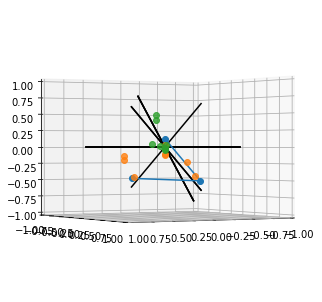

In [4]:
atom_positions = np.array(atom_positions)
#  Random pertubation of atom positions to simulate a new conformation
atom_positions_plus = atom_positions #+ [[0,0.01,0.01], [0.01,0,0.01], [0.02,0.02,0.02]]
#  Find the new axes for this conformation
frame_vectors_plus = get_local_axis(atom_positions_plus, frame_atoms)




def plot_axe(x_local_vector, y_local_vector, z_local_vector, c="k"):
    x = [-x_local_vector[0], 0, x_local_vector[0]]
    y = [-x_local_vector[1], 0, x_local_vector[1]]
    z = [-x_local_vector[2], 0, x_local_vector[2]]
    plt.plot(x, y, z, c=c)
    x = [-y_local_vector[0], 0, y_local_vector[0]]
    y = [-y_local_vector[1], 0, y_local_vector[1]]
    z = [-y_local_vector[2], 0, y_local_vector[2]]
    plt.plot(x, y, z, c=c)
    x = [-z_local_vector[0], 0, z_local_vector[0]]
    y = [-z_local_vector[1], 0, z_local_vector[1]]
    z = [-z_local_vector[2], 0, z_local_vector[2]]
    plt.plot(x, y, z, c=c)

fig = plt.figure()
ax = Axes3D(fig, elev=0, azim=60)
# Transpose to the right shape for plotting
a_p = np.array(atom_positions).T
a_p1 = np.array(atom_positions_plus).T
c_p = np.array(c_positions).T
c_p_l = np.array(c_positions_local).T
# Plotting
for x_local_vector, y_local_vector, z_local_vector in zip(*frame_vectors[0]):
    plot_axe(x_local_vector, y_local_vector, z_local_vector)
# for x_local_vector, y_local_vector, z_local_vector in zip(*frame_vectors_plus[0]):
#     plot_axe(x_local_vector, y_local_vector, z_local_vector) 
    

#plot_axe(*frame_vectors_plus[0], c="b")
plt.plot(a_p[0], a_p[1], a_p[2], marker="o")
# plt.plot(a_p1[0], a_p1[1], a_p1[2], marker="o")
plt.plot(c_p[0], c_p[1], c_p[2], marker="o", linestyle = 'None', alpha=0.8)
plt.plot(c_p_l[0], c_p_l[1], c_p_l[2], marker="o", linestyle = 'None', alpha=0.8)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
    
plt.show()

In [5]:
c_positions_local

array([[-1.65449518e-07,  1.09996171e-04, -1.48997087e-02],
       [-6.69670749e-07,  1.16844221e-04, -3.69172663e-02],
       [-8.67996662e-06,  1.21206587e-04, -3.90284556e-02],
       [-2.57152233e-07, -2.90048536e-01,  4.33655005e-02],
       [-1.36735549e-06, -1.02693956e-01,  1.04944924e-02],
       [-2.02288192e-06, -2.00643750e-01,  4.06455230e-01],
       [-1.00858477e-06,  3.51325275e-02,  2.26291508e-02],
       [ 1.93456037e-06, -1.94651820e-01,  4.88618994e-01]])

In [6]:
"""
Local ==> Global
"""
#  Find the position of the charges in the local axes
#  Create a new array for the 'local' charges
c_pos_shape = np.array(c_positions).shape

c_new_local = np.zeros(c_pos_shape)
c_positions_global = np.zeros(c_pos_shape)
used_atoms = []

for f in range(n_frames):
    ex, ey, ez = frame_vectors[f]
    ex_p, ey_p, ez_p = frame_vectors_plus[f]
    #  Loop through the atoms in the frame
    for ai, atom_index in zip(range(len(frame_atoms[f])), frame_atoms[f]):
        #  adjust indexing
        atom_index = atom_index - 1
        if atom_index in list(atom_charge_dict.keys()) and atom_index not in used_atoms:
            charges = atom_charge_dict[atom_index]
            #  Find the associated charges for that atom, and loop
            for charge in charges:
                c_pos_local = c_positions_local[charge]
                atom_pos_xyz = atom_positions_plus[atom_index]
                # 
                                
                local_x_pos =  np.multiply(ex_p[ai], c_pos_local[0])
                local_y_pos =  np.multiply(ey_p[ai], c_pos_local[1])
                local_z_pos =  np.multiply(ez_p[ai], c_pos_local[2])
                
                c_positions_global[charge][0] = local_x_pos.sum()
                c_positions_global[charge][1] = local_y_pos.sum()
                c_positions_global[charge][2] = local_z_pos.sum()
                
                c_positions_global[charge][0] = c_positions_global[charge][0] + 1 * atom_pos_xyz[0]
                c_positions_global[charge][1] = c_positions_global[charge][1] + 1 * atom_pos_xyz[1]
                c_positions_global[charge][2] = c_positions_global[charge][2] + 1 * atom_pos_xyz[2]
                
        used_atoms.append(atom_index)


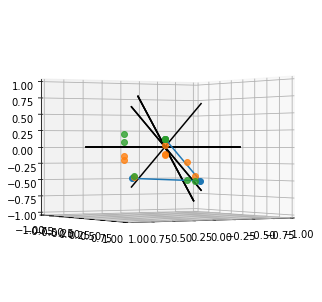

In [7]:
fig = plt.figure()
ax = Axes3D(fig, elev=0, azim=60)
# Transpose to the right shape for plotting
a_p = np.array(atom_positions).T
a_p1 = np.array(atom_positions_plus).T
c_p = np.array(c_positions).T
c_p_l = np.array(c_positions_global).T

# Plotting
for x_local_vector, y_local_vector, z_local_vector in zip(*frame_vectors_plus[0]):
    plot_axe(x_local_vector, y_local_vector, z_local_vector) 
    
#plot_axe(*frame_vectors_plus[0], c="b")
#plt.plot(a_p[0], a_p[1], a_p[2],  marker="o")
plt.plot(a_p1[0], a_p1[1], a_p1[2], marker="o")
plt.plot(c_p[0], c_p[1], c_p[2], marker="o", linestyle = 'None', alpha=0.8)
plt.plot(c_p_l[0], c_p_l[1], c_p_l[2], marker="o", linestyle = 'None', alpha=0.8)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
    
plt.show()

In [8]:
c_positions_global

array([[ 2.60478228e-08,  1.09996171e-04,  1.20034358e-01],
       [ 1.05430739e-07,  1.16844221e-04,  1.16567987e-01],
       [ 1.36654513e-06,  1.21206587e-04,  1.16235608e-01],
       [ 4.04851938e-08,  4.76238389e-01, -4.82693684e-01],
       [ 2.15271908e-07,  6.63592970e-01, -4.87868787e-01],
       [ 3.18475813e-07, -9.66930676e-01,  8.17205063e-02],
       [ 1.58788238e-07, -7.31154398e-01, -4.57717477e-01],
       [-3.04570761e-07, -9.60938746e-01,  1.97195347e-01]])

In [9]:
c_positions

[[1.0508956235e-06, 0.0001099961714895, 0.0277407456572774],
 [4.2535878526e-06, 0.0001168442214059, -0.1121094951886629],
 [5.51330644221e-05, 0.0001212065873684, -0.1255192626269133],
 [1.6333692556e-06, 0.4762383894293314, -0.2140737552996062],
 [8.685113839e-06, 0.6635929700945736, -0.4228625080122869],
 [1.28488603766e-05, -0.9669306758555397, -0.2003160881260604],
 [6.4062883867e-06, -0.7311543984088528, -0.4734196947457587],
 [-1.22878630847e-05, -0.960938746311971, -0.1418541396614728]]